In [1]:
# %%
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from matplotlib.animation import FuncAnimation

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# %%
# Create output directory
output_dir = os.path.join(os.getcwd(), "woSubstrate")
os.makedirs(output_dir, exist_ok=True)

In [3]:
# %%
# Function to export tensor to CSV using NumPy
def export_tensor_to_csv_numpy(tensor, filename):
    array = tensor.detach().cpu().numpy()

    # Ensure the array is of floating-point type
    if not np.issubdtype(array.dtype, np.floating):
        array = array.astype(np.float64)
    
    # Save with double precision and '.' as decimal delimiter
    np.savetxt(filename, array, delimiter=',', fmt='%.15f')
    print(f"Exported tensor to {filename} using NumPy with double precision.")



In [4]:
import shutil

# Hyperparameters
grid_size = 100  # Adjusted to match MATLAB's gridSize
total_iterations = 40000  # Adjusted to match MATLAB's totalIterations
depth = 2
alpha_mat = torch.zeros((grid_size, grid_size), device=device)

# Reaction-Diffusion parameters
pa = 0.8
# pa = 0.54545455 
# pb = 0.6
pb = 0.82
pe = 3.5
d = 30
dt = 1e-5
threshold = 1
gamma = 625
ph = 1
alpha = 1
amax = 30 # activator limiter 20
smax = 1e6 # suppressor limiter 40
rnd_subs = 0.025 # random variation. If it results in values greater than 1, the values are capped
rand_val = 0.975 # random mean

# Laplacian weights
lap = 6.8/13.6
lap_side = 1/13.6
lap_diag = .7/13.6

# Environmental factors
substrate_val = 1
T = 35  # temperature
H = 95  # humidity
intensity = 80  # light intensity
wavelength = 630  # wavelength
a1, a2, a3 = 3, 3, 3  # Example exponents for combined effect scaling
code_selector = 3 # 0 for substrate, 1 for temperature, 2 for humidity, 3 for light

if code_selector == 0:
    string = "substrate"
    unit = "mol_per_cell"
    formatted_measurement = f"{substrate_val:.3f}".rstrip('0').rstrip('.') if '.' in f"{substrate_val:.3f}" else f"{substrate_val:.3f}"
    formatted_val = f"{string}{formatted_measurement}{unit}"
elif code_selector == 1:
    string = "temperature"  # Corrected the spelling here
    unit = "Celsius"
    formatted_measurement = f"{T:.3f}".rstrip('0').rstrip('.') if '.' in f"{T:.3f}" else f"{T:.3f}"
    formatted_val = f"{string}{formatted_measurement}{unit}"
elif code_selector == 2:
    string = "humidity"
    unit = "percent"
    formatted_measurement = f"{H:.3f}".rstrip('0').rstrip('.') if '.' in f"{H:.3f}" else f"{H:.3f}"
    formatted_val = f"{string}{formatted_measurement}{unit}"
elif code_selector == 3:
    string1 = "intensity"
    string2 = "wavelength"
    unit_intensity = "lux"
    unit_wavelength = "nm"
    formatted_intensity = f"{intensity:.3f}".rstrip('0').rstrip('.') if '.' in f"{intensity:.3f}" else f"{intensity:.3f}"
    formatted_wavelength = f"{wavelength:.3f}".rstrip('0').rstrip('.') if '.' in f"{wavelength:.3f}" else f"{wavelength:.3f}"
    formatted_val = f"{string1}{formatted_intensity}{unit_intensity}_{string2}{formatted_wavelength}{unit_wavelength}"

output_directory = f"D:\\Fungateria\\Code\\Final\\{formatted_val}"
# os.makedirs(output_directory, exist_ok=True)

# Ensure the directory exists and clear its contents if it already exists
if os.path.exists(output_directory):
    # If the directory exists, clear its contents
    for filename in os.listdir(output_directory):
        file_path = os.path.join(output_directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file or symbolic link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the subdirectory
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
else:
    # If the directory doesn't exist, create it
    os.makedirs(output_directory)

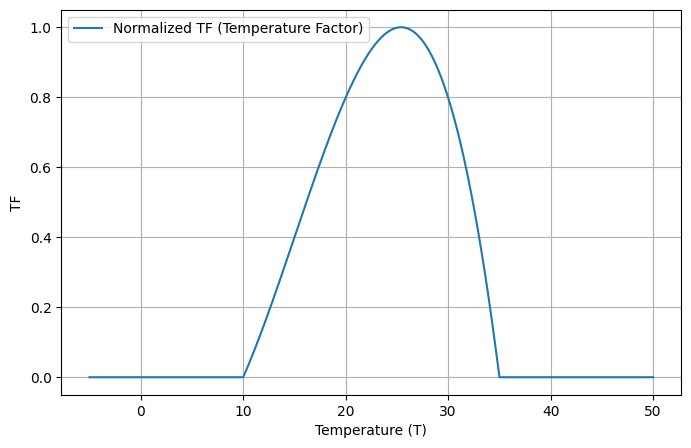

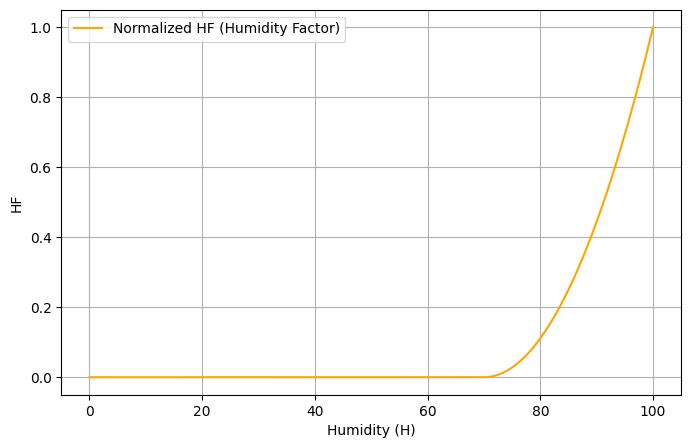

C:\Users\itomp\AppData\Local\Temp\ipykernel_37620\2151821215.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


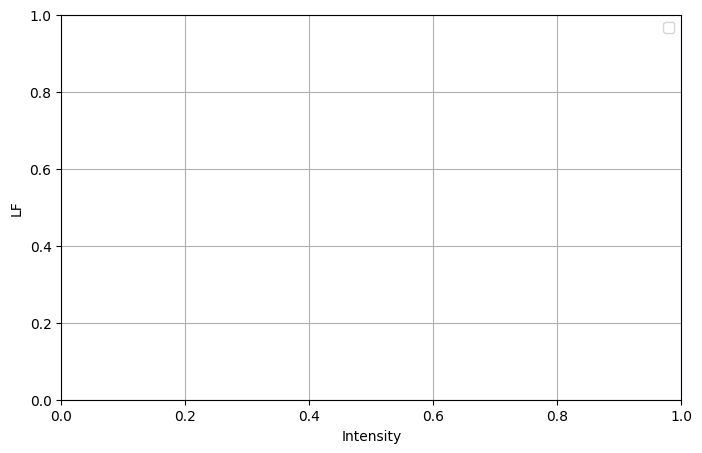

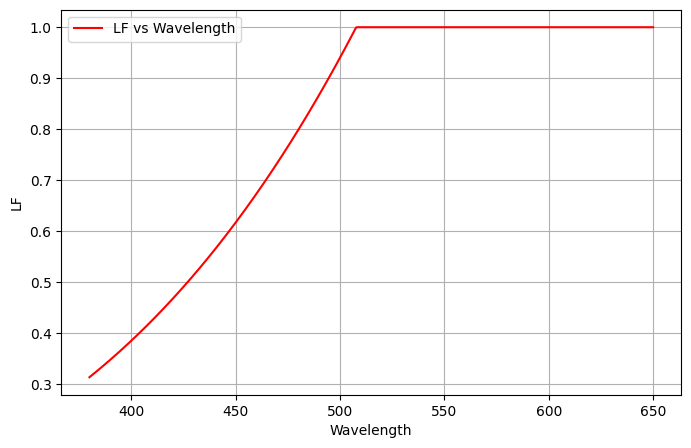

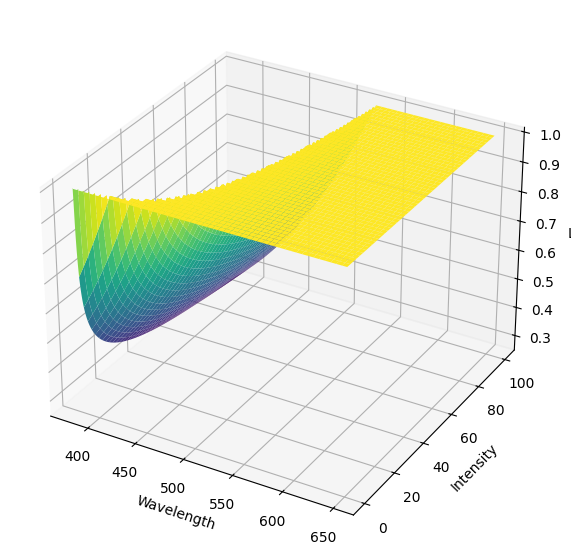

In [5]:
# IGNORE!!!
# This is just for plotting the environmentaleffects

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Normalize a function to range [0, 1]
def normalize(values):
    return (values - np.min(values)) / (np.max(values) - np.min(values))

# # Embedding Mycelium Features
# # Those features are temperature, humidity, light (intensity and wavelength).

# #  Temperature

# # source: https://www.tandfonline.com/doi/full/10.1080/09583157.2021.1993133 

# # All models provided statistical estimates for the parameters when fitted with conidial germination and mycelial growth datasets of EPF isolates. Curves plotted from fitted models'
# # predicted values for conidial germination and mycelial growth of EPF isolates against
# # temperature showed obvious nonlinear patterns. Conidial germination for all EPF isolates started from around 10 - 14 C and reached a peak at near 25 - 30 C, followed by a
# # precipitous decline reaching upper thresholds near 35 - 38 deg C (Figure 1). Mycelial
# # growth for all EPF isolates started from around 0 - 14 C with a peak at near 25 - 30 C, followed by a quick decline towards upper thresholds near 35 42 C (Figure 2).
def calculate_TF(T, Tmin=10, Tmax=35):
    TF = T * (T - Tmin) * (Tmax - T)
    TF = np.where((T < Tmin) | (T > Tmax), 0, TF)
    return normalize(TF)

# # Humidity

# # The sources are: https://pdfs.semanticscholar.org/f047/53e7bb888e8cd392f749676081697bfbb45f.pdf and https://amhuru.com/understanding-the-best-humidity-for-mycelium-growth/

# # After a certain
# # date (which varies with the locality) and assuming that inoculum on volunteer plants is always
# # Fig 5.27 Fungicides against P. infestans. (a) The dithiocarbamate maneb which is active against Oomycota and Eumycota. (b) The
# # isothiocyanate radical released by metabolism of dithiocarbamates by fungal hyphae. (c) The phenylamide metalaxyl which is active
# # only against Oomycota. (d) Aluminium ethyl phosphonate (fosetyl-Al). (e) Cyazofamid, a new fungicide specific against Oomycota.
# # (f) Famoxadone, a new fungicide active against Oomycota and Eumycota.
# # PYTHIALES 113
# # present, Beaumont (1947) predicted that blight
# # would follow within 1522 days of a period
# # of at least 48 h during which the minimum temperature was not less than 10C and the relative
# # humidity was over 75%. 
def calculate_HF(H):
    Hmin = 70
    HF = 0.00116428571 * H**2 - 0.16295 * H + 5.6625
    HF = normalize(HF)
    HF = np.where(H < Hmin, 0, HF)
    return normalize(HF)

# The light's effect. There are no mathematical formula's available, only empirical data which showcase how the light is linked to fungal growth. It generally impedes it. 
# The source is: https://journals.asm.org/doi/10.1128/spectrum.00213-21
def calculate_LF(intensity, wavelength):
    LF = 4e-11 * wavelength**4 / (1e-4 + intensity**0.25)
    LF = np.clip(LF, 0, 1)  # Ensures LF remains in [0, 1]
    return LF

# Generate data ranges
T_range = np.linspace(-5, 50, 500)
H_range = np.linspace(0, 100, 500)
intensity_range = np.linspace(0, 100, 500)
wavelength_range = np.linspace(380, 650, 500)

# Calculate values
TF_values = calculate_TF(T_range)
HF_values = calculate_HF(H_range)
LF_intensity = calculate_LF(intensity_range, np.mean(wavelength_range))
LF_wavelength = calculate_LF(np.mean(intensity_range), wavelength_range)

# Plot TF
plt.figure(figsize=(8, 5))
plt.plot(T_range, TF_values, label="Normalized TF (Temperature Factor)")
# plt.title("Normalized Temperature Factor (TF)")
plt.xlabel("Temperature (T)")
plt.ylabel("TF")
plt.grid()
plt.legend()
plt.show()

# Plot HF
plt.figure(figsize=(8, 5))
plt.plot(H_range, HF_values, label="Normalized HF (Humidity Factor)", color="orange")
# plt.title("Normalized Humidity Factor (HF)")
plt.xlabel("Humidity (H)")
plt.ylabel("HF")
plt.grid()
plt.legend()
plt.show()

# Plot LF vs Intensity
plt.figure(figsize=(8, 5))
# plt.plot(intensity_range, LF_intensity, label="LF vs Intensity", color="blue")
# plt.title("Light Factor (LF) vs Intensity")
plt.xlabel("Intensity")
plt.ylabel("LF")
plt.grid()
plt.legend()
plt.show()

# Plot LF vs Wavelength
plt.figure(figsize=(8, 5))
plt.plot(wavelength_range, LF_wavelength, label="LF vs Wavelength", color="red")
# plt.title("Light Factor (LF) vs Wavelength")
plt.xlabel("Wavelength")
plt.ylabel("LF")
plt.grid()
plt.legend()
plt.show()

# Create meshgrid for 3D plot
intensity_mesh, wavelength_mesh = np.meshgrid(intensity_range, wavelength_range)
LF_3D = calculate_LF(intensity_mesh, wavelength_mesh)

# 3D plot of LF vs Intensity and Wavelength
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(wavelength_mesh, intensity_mesh, LF_3D, cmap='viridis', edgecolor='none')
# ax.set_title("3D Plot of LF")
ax.set_xlabel("Wavelength")
ax.set_ylabel("Intensity")
ax.set_zlabel("LF")
plt.show()


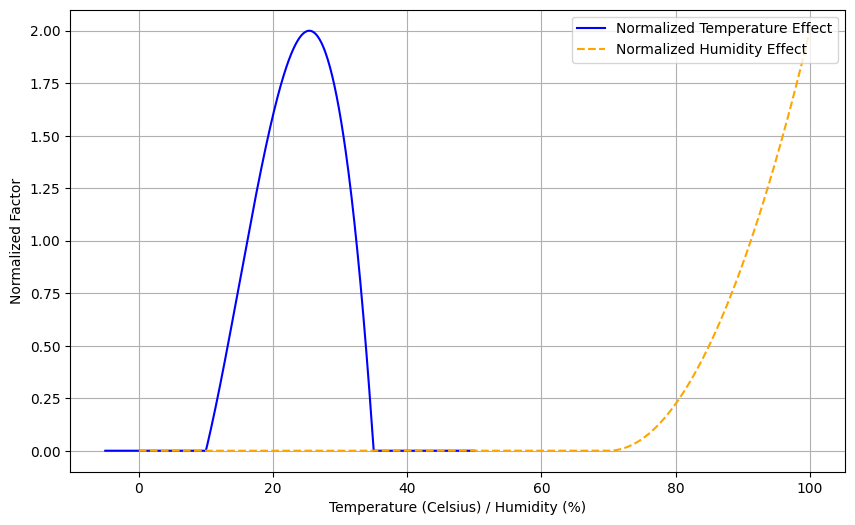

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize a function to range [0, 1]
def normalize(values):
    return 2*(values - np.min(values)) / (np.max(values) - np.min(values))

# Temperature Factor (TF)
def calculate_TF(T, Tmin=10, Tmax=35):
    TF = T * (T - Tmin) * (Tmax - T)
    TF = np.where((T < Tmin) | (T > Tmax), 0, TF)
    return normalize(TF)

# Humidity Factor (HF)
def calculate_HF(H):
    Hmin = 70
    HF = 0.00116428571 * H**2 - 0.16295 * H + 5.6625
    HF = normalize(HF)
    HF = np.where(H < Hmin, 0, HF)
    return normalize(HF)

# Generate data ranges
T_range = np.linspace(-5, 50, 500)
H_range = np.linspace(0, 100, 500)

# Calculate values
TF_values = calculate_TF(T_range)
HF_values = calculate_HF(H_range)

# Combine TF and HF plots
plt.figure(figsize=(10, 6))
plt.plot(T_range, TF_values, label="Normalized Temperature Effect", color="blue")
plt.plot(H_range, HF_values, label="Normalized Humidity Effect", color="orange", linestyle="--")

# Add labels, grid, and legend
plt.xlabel("Temperature (Celsius) / Humidity (%)")
plt.ylabel("Normalized Factor")
# plt.title("Temperature and Humidity Factors")
plt.grid(True)
plt.legend()
plt.show()

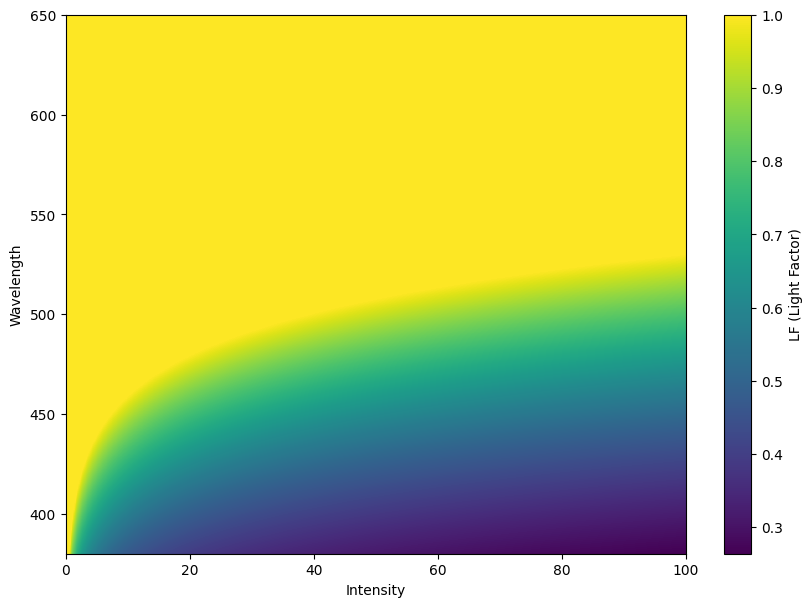

In [7]:
# Generate data ranges
intensity_range = np.linspace(0, 100, 500)
wavelength_range = np.linspace(380, 650, 500)

# Create meshgrid for 2D plot
intensity_mesh, wavelength_mesh = np.meshgrid(intensity_range, wavelength_range)
LF_2D = calculate_LF(intensity_mesh, wavelength_mesh)

# Create 2D heatmap
plt.figure(figsize=(10, 7))
plt.imshow(LF_2D, extent=[0, 100, 380, 650], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='LF (Light Factor)')
plt.xlabel("Intensity")
plt.ylabel("Wavelength")
# plt.title("2D Heatmap of LF vs Intensity and Wavelength")
plt.show()

In [8]:
# %%
# Initialize activator, suppressor, and mycelium matrices as PyTorch tensors
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

u_new = torch.zeros_like(u)
v_new = torch.zeros_like(v)
c_new = torch.zeros_like(c)

# Initialize nutrient landscape
mid = grid_size // 2

# n = torch.linspace(substrate_val, substrate_val, grid_size, device=device)
# n = n.repeat(grid_size, 1)
rand_mat = torch.linspace(1, rand_val, grid_size, device=device)
rand_mat = rand_mat.repeat(grid_size, 1)
rand_mat = torch.min(rand_mat * (1 - rnd_subs + torch.rand((grid_size, grid_size), device=device) * rnd_subs * 2), torch.ones_like(rand_mat))
# rand_mat = rand_mat * (1 - rnd_subs + torch.rand((grid_size, grid_size), device=device) * rnd_subs * 2)

rand_mat = rand_mat.clone()

print(mid)

print(rand_mat)
print(u.shape)
print(v.shape)
print(c.shape)

rand_tensor = torch.tensor(rand_mat, dtype=torch.float32, device=device)

print(torch.min(rand_tensor))
print(torch.max(rand_tensor))

50
tensor([[1.0000, 0.9815, 0.9749,  ..., 0.9586, 0.9685, 0.9782],
        [0.9787, 1.0000, 1.0000,  ..., 0.9696, 0.9921, 0.9950],
        [0.9791, 0.9812, 0.9977,  ..., 0.9768, 0.9884, 0.9829],
        ...,
        [1.0000, 1.0000, 0.9761,  ..., 0.9679, 0.9762, 0.9687],
        [1.0000, 1.0000, 1.0000,  ..., 0.9874, 0.9525, 0.9522],
        [1.0000, 0.9762, 0.9895,  ..., 0.9990, 0.9720, 0.9545]],
       device='cuda:0')
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])
tensor(0.9507, device='cuda:0')
tensor(1., device='cuda:0')


C:\Users\itomp\AppData\Local\Temp\ipykernel_37620\1084584764.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_tensor = torch.tensor(rand_mat, dtype=torch.float32, device=device)


In [9]:
import numpy as np
import torch

# Temperature function for a single value
def calculate_TF_single(T, Tmin=10, Tmax=35):
    if T <= Tmin or T >= Tmax:
        return 0
    TF = T * (T - Tmin) * (Tmax - T)
    return TF / 3755.128122738977  # Normalized to [0, 1]

# Updated Humidity function for a single value
def calculate_HF_single(H):
    Hmin = 70
    HF = 0.00116428571 * H**2 - 0.16295 * H + 5.6625
    if H <= Hmin:
        return 0  # Ensure no negative values
    return HF  # Normalize based on max value of the quadratic equation

# Updated Light function for a single value
def calculate_LF(intensity, wavelength):
    LF = 4e-11 * wavelength**4 / (1e-4 + intensity**0.25)
    if LF > 1: # Clip to [0, 1]
        LF = 1
    return LF  

# Combine growth effects and create the grid
def calculate_growth_effect(T, H, intensity, wavelength, grid_size, a1, a2, a3, env_select):
    # Calculate individual effects
    TF = calculate_TF_single(T)  # Calculate TF for the given temperature
    HF = calculate_HF_single(H)  # Calculate HF for the given humidity
    LF = calculate_LF(intensity, wavelength)  # Calculate LF for the given light conditions
    
    # Combined effect
    combined_effect = TF**(1/a1) * HF**(1/a2) * LF**(1/a3)

    if env_select == 0:
        growth_grid = substrate_val * rand_mat # only substrate
    elif env_select == 1:
        growth_grid = TF**(1/a1) * rand_mat # only temperature
    elif env_select == 2:
        growth_grid = HF**(1/a2) * rand_mat # only humidity
    elif env_select == 3:
        growth_grid = LF**(1/a3) * rand_mat #only light
    
    # Create a grid with the combined effect
    # growth_grid = combined_effect * np.ones((grid_size, grid_size))
    
    return growth_grid

growth_effect_grid = calculate_growth_effect(T, H, intensity, wavelength, grid_size, a1, a2, a3, code_selector)

# Display the growth effect grid
print("Growth Effect Grid:")
print(growth_effect_grid)

# Create a PyTorch tensor for GPU processing
growth_effect_tensor = torch.tensor(growth_effect_grid, dtype=torch.float32, device=device)

print(torch.min(growth_effect_tensor))
print(torch.max(growth_effect_tensor))

Growth Effect Grid:
tensor([[1.0000, 0.9815, 0.9749,  ..., 0.9586, 0.9685, 0.9782],
        [0.9787, 1.0000, 1.0000,  ..., 0.9696, 0.9921, 0.9950],
        [0.9791, 0.9812, 0.9977,  ..., 0.9768, 0.9884, 0.9829],
        ...,
        [1.0000, 1.0000, 0.9761,  ..., 0.9679, 0.9762, 0.9687],
        [1.0000, 1.0000, 1.0000,  ..., 0.9874, 0.9525, 0.9522],
        [1.0000, 0.9762, 0.9895,  ..., 0.9990, 0.9720, 0.9545]],
       device='cuda:0')
tensor(0.9507, device='cuda:0')
tensor(1., device='cuda:0')


C:\Users\itomp\AppData\Local\Temp\ipykernel_37620\1254917730.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  growth_effect_tensor = torch.tensor(growth_effect_grid, dtype=torch.float32, device=device)


In [10]:
# Initial activator and suppressor states
cen_span = 5
random_tensor = 0.2
cen_point = int(grid_size/2)

counter_init = torch.zeros((grid_size, grid_size), device=device)


for k in range(-cen_span, cen_span+1):
    for l in range(-cen_span, cen_span+1):
        if math.sqrt(k*k+l*l) <= cen_span:  # Check to ensure indices are within bounds
            # c[cen_point+k, cen_point+l] = 0.8 * (1 - random_tensor + torch.rand((1, 1), device=device) * random_tensor * 2)
            # u[cen_point+k, cen_point+l] = 0.5 * (1 - random_tensor + torch.rand((1, 1), device=device) * random_tensor * 2) 
            # v[cen_point+k, cen_point+l] = 0.1 * (1 - random_tensor + torch.rand((1, 1), device=device) * random_tensor * 2)
            c[cen_point+k, cen_point+l] = 0.8
            u[cen_point+k, cen_point+l] = 0.5
            v[cen_point+k, cen_point+l] = 0.1
            counter_init[cen_point+k, cen_point+l]  = 1

print(torch.sum(counter_init))

tensor(81., device='cuda:0')


In [11]:
# %%
# Define filenames with step number
filename_c = os.path.join(output_dir, f'c_init.csv')
filename_u = os.path.join(output_dir, f'u_init.csv')
filename_v = os.path.join(output_dir, f'v_init.csv')
filename_n = os.path.join(output_dir, f'n_init.csv')

# Export tensors to CSV using NumPy
export_tensor_to_csv_numpy(c, filename_c)
export_tensor_to_csv_numpy(u, filename_u)
export_tensor_to_csv_numpy(v, filename_v)
export_tensor_to_csv_numpy(growth_effect_tensor, filename_n)

import matplotlib.pyplot as plt
import os

# def update_visualization(step, u, v, c, n, output_dir):
#     fig = plt.figure(figsize=(15, 15))
    
#     # Activator u
#     ax1 = fig.add_subplot(221)
#     img1 = ax1.imshow(u.cpu().numpy(), cmap='viridis', vmin=0, vmax=amax)
#     ax1.set_title(f'Activator u at iteration {step}')
#     fig.colorbar(img1, ax=ax1)  # Add colorbar for this subplot

#     # Suppressor v
#     ax2 = fig.add_subplot(222)
#     img2 = ax2.imshow(v.cpu().numpy(), cmap='viridis', vmin=0, vmax=smax)
#     ax2.set_title(f'Suppressor v at iteration {step}')
#     fig.colorbar(img2, ax=ax2)  # Add colorbar for this subplot

#     # Mycelium c
#     ax3 = fig.add_subplot(223)
#     img3 = ax3.imshow(c.cpu().numpy(), cmap='Purples', vmin=0, vmax=1)
#     ax3.set_title(f'Mycelium at iteration {step}')
#     fig.colorbar(img3, ax=ax3)  # Add colorbar for this subplot

#     # Substrate n
#     ax4 = fig.add_subplot(224)
#     img4 = ax4.imshow(n.cpu().numpy(), cmap='ocean', vmin=0, vmax=1)
#     ax4.set_title(f"{formatted_val}")
#     fig.colorbar(img4, ax=ax4)  # Add colorbar for this subplot

#     plt.tight_layout()
#     plt.savefig(os.path.join(output_dir, f'visualization_step_{step}.png'))  # Save the figure to file
#     plt.show()
#     plt.close(fig)  # Close the figure to free memory

def update_visualization(step, u, v, c, n, output_dir):
    fig = plt.figure(figsize=(6, 6))  # Adjusted the figure size for a single subplot
    
    # Mycelium c
    ax = fig.add_subplot(111)  # Create a single subplot
    img = ax.imshow(c.cpu().numpy(), cmap='Purples', vmin=0, vmax=1)
    # ax.set_title(f'Mycelium at iteration {step}')
    # fig.colorbar(img, ax=ax)  # Add colorbar for this subplot
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'c_visualization_step_{step}.png'))  # Save the figure to file
    plt.close(fig)  # Close the figure to free memory


Exported tensor to c:\Users\itomp\Downloads\woSubstrate\c_init.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\u_init.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\v_init.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\n_init.csv using NumPy with double precision.


In [12]:
# %%
# # Pre-calculate the Laplacian kernel indices and weights if they remain constant
L = torch.zeros((2*depth+1, 2*depth+1), device=device)
for dx in range(-depth, depth + 1):
    for dy in range(-depth, depth + 1):
        if dx == 0 and dy == 0:
            L[depth, depth] = 0
        else:
            L[depth + dx, depth + dy] = 1/np.sqrt(dx**2+dy**2)

print(L)
print(L.shape)

repeat_factor = grid_size // 5
D = L.repeat(repeat_factor, repeat_factor)


print(f"D shape: {D.shape}")  # Should be (grid_size, grid_size)

tensor([[0.3536, 0.4472, 0.5000, 0.4472, 0.3536],
        [0.4472, 0.7071, 1.0000, 0.7071, 0.4472],
        [0.5000, 1.0000, 0.0000, 1.0000, 0.5000],
        [0.4472, 0.7071, 1.0000, 0.7071, 0.4472],
        [0.3536, 0.4472, 0.5000, 0.4472, 0.3536]], device='cuda:0')
torch.Size([5, 5])
D shape: torch.Size([100, 100])


In [13]:
# %%
import torch.nn.functional as F

def conv2_same(input_tensor, kernel):
    # Ensure the kernel has 4 dimensions
    if kernel.dim() == 2:
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, kH, kW]
    elif kernel.dim() == 4:
        pass  # Already in the correct shape
    else:
        raise ValueError("Kernel must be a 2D or 4D tensor.")
    
    # Extract kernel dimensions
    _, _, kH, kW = kernel.shape
    
    # Calculate padding for 'same' convolution
    pad_h = (kH - 1) // 2
    pad_w = (kW - 1) // 2
    
    # Reshape input to [N, C, H, W]
    input_reshaped = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
    
    # Perform convolution with calculated padding
    conv_result = F.conv2d(input_reshaped, kernel, padding=(pad_h, pad_w))
    
    # Reshape back to [H, W]
    return conv_result.squeeze(0).squeeze(0)

In [14]:
# The normalization

tensor_0_85 = 1.2*torch.ones((grid_size, grid_size), device=device)

growth_effect_tensor = (0.6*growth_effect_tensor+tensor_0_85)

In [15]:
# %%
# Precompute the possible shifts and their corresponding weights based on depth
# Since depth is fixed, shifts and weights can be precomputed
shifts = []
weights = []
for dx in range(-depth, depth + 1):
    for dy in range(-depth, depth + 1):
        if dx == 0 and dy == 0:
            continue  # Skip the center
        distance = (dx**2 + dy**2) ** 0.5
        if distance <= 1:
            weight = 1.0
        else:
            weight = 1.0 / distance
        shifts.append((dx, dy))
        weights.append(weight)

# Convert weights to a tensor for vectorized operations
weights = torch.tensor(weights, dtype=torch.float32, device=device)

# Main simulation loop
for step in range(total_iterations+1):
    f_uv = (pa * u + u ** 2 - pb * u * v) * (growth_effect_tensor)
    g_uv = pe * u ** 3 - v

    # 2. Create a binary mask where c > 0.5
    c_positive = (c > 0.5).float()

    # 3. Initialize a list to store all shifted contributions
    shifted_contributions = []

    for idx, (dx, dy) in enumerate(shifts):
        weight = weights[idx]

        # Shift the c_positive mask
        if dx > 0:
            shifted = F.pad(c_positive, (0, 0, dx, 0))[:-dx, :]
        elif dx < 0:
            shifted = F.pad(c_positive, (0, 0, 0, -dx))[-dx:, :]
        else:
            shifted = c_positive.clone()

        if dy > 0:
            shifted = F.pad(shifted, (dy, 0, 0, 0))[:, :-dy]
        elif dy < 0:
            shifted = F.pad(shifted, (0, -dy, 0, 0))[:, -dy:]
        # else dy == 0: no padding needed

        # Multiply by the corresponding weight
        contribution = shifted * weight

        # Append to the list
        shifted_contributions.append(contribution)

    # 4. Stack all contributions and take the element-wise maximum
    if shifted_contributions:
        # Stack along a new dimension and compute max across that dimension
        stacked_contributions = torch.stack(shifted_contributions, dim=0)  # Shape: (num_shifts, H, W)
        ij_mat = torch.max(stacked_contributions, dim=0).values  # Shape: (H, W)
    else:
        ij_mat = torch.zeros_like(c_positive, device=device)

    # 5. For cells where distance <=1, set ij_mat to 1 where c >0.5
    # This ensures that cells with c > 0.5 have their ij_mat neighbors set correctly
    # According to MATLAB logic, cells within distance <=1 should be set to 1
    ij_mat = torch.where(c_positive == 1, torch.ones_like(ij_mat), ij_mat)

    # 6. Update ij_new based on neighbor conditions
    # Pad ij_mat to handle boundary conditions
    pad_ij = F.pad(ij_mat, (1, 1, 1, 1), mode='constant', value=0)

    # Extract immediate neighbors (up, down, left, right)
    neighbors_immediate = torch.stack([
        pad_ij[:-2, 1:-1],  # Up
        pad_ij[2:, 1:-1],   # Down
        pad_ij[1:-1, :-2],  # Left
        pad_ij[1:-1, 2:]    # Right
    ], dim=0)
    has_zero_immediate = (neighbors_immediate == 0).any(dim=0)

    # Extract diagonal neighbors (up-left, up-right, down-left, down-right)
    neighbors_diagonal = torch.stack([
        pad_ij[:-2, :-2],  # Up-Left
        pad_ij[:-2, 2:],   # Up-Right
        pad_ij[2:, :-2],   # Down-Left
        pad_ij[2:, 2:]     # Down-Right
    ], dim=0)
    has_zero_diagonal = (neighbors_diagonal == 0).any(dim=0)

    # Initialize ij_new as a clone of ij_mat
    ij_new = ij_mat.clone()

    # Apply conditions to update ij_new
    ij_new = torch.where(
        (ij_mat > 0) & has_zero_immediate,
        torch.zeros_like(ij_new),
        ij_new
    )
    ij_new = torch.where(
        (ij_mat > 0) & has_zero_diagonal,
        ij_mat / 2.0,
        ij_new
    )

    # 7. Compute Diffusion Using Convolution with Laplacian Kernel L
    conv_u = conv2_same(u, L)
    conv_v = conv2_same(v, L)

    # 8. Update Concentrations
    v_new = v + dt * (d * conv_v + gamma * g_uv)
    u_new = u + dt * (ij_new * (conv_u + gamma * f_uv))

    # 10. Compute alpha
    alpha = torch.where(
        u <= threshold,
        torch.tensor(0.49, device=device),
        0.49 - 2.5 * (u - threshold)
    )

    # 11. Update c_new
    c_new = c + dt * gamma * ph * c * (alpha - c) * (c - 1)

    # 12. Apply Random Noise Where alpha < 0
    noise_condition = (alpha < 0)
    random_noise = torch.rand_like(c) * 0.015
    c_new = torch.where(noise_condition, c_new + random_noise, c_new)

    # 13. Ensure u_new and v_new Are Non-Negative and Clamp Values
    u_new = torch.clamp(u_new, min=0, max=amax)
    v_new = torch.clamp(v_new, min=0, max=smax)
    c_new = torch.clamp(c_new, max=1)

    # 14. Check for NaNs or Infs
    if torch.isnan(u_new).any() or torch.isnan(v_new).any() or torch.isnan(c_new).any():
        print(f"NaN detected at step {step + 1}. Terminating simulation.")
        break
    if torch.isinf(u_new).any() or torch.isinf(v_new).any() or torch.isinf(c_new).any():
        print(f"Infinity detected at step {step + 1}. Terminating simulation.")
        break

    # 15. Update Variables for the Next Iteration
    u, v, c = u_new, v_new, c_new

    if step % 5000 == 0:

        # Define filenames with step number
        filename_c = os.path.join(output_dir, f'c_step_{step}.csv')
        filename_u = os.path.join(output_dir, f'u_step_{step}.csv')
        filename_v = os.path.join(output_dir, f'v_step_{step}.csv')
        filename_n = os.path.join(output_dir, f'n_step_{step}.csv')
        
        # Export tensors to CSV using NumPy
        export_tensor_to_csv_numpy(c, filename_c)
        # export_tensor_to_csv_numpy(u, filename_u)
        # export_tensor_to_csv_numpy(v, filename_v)
        # export_tensor_to_csv_numpy(growth_effect_tensor, filename_n)

        update_visualization(step, u, v, c, growth_effect_tensor, output_directory)

Exported tensor to c:\Users\itomp\Downloads\woSubstrate\c_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\c_step_5000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\c_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\c_step_15000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\c_step_20000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\c_step_25000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\c_step_30000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\c_step_35000.csv using NumPy with double precision.
Exported tensor to c:\Users\itomp\Downloads\woSubstrate\c_step_40000.csv using NumPy with double precision.


In [16]:
print(torch.sum(c))
print(torch.max(c))
print(torch.min(c))

tensor(1050.3180, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')


In [17]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects
from collections import deque
import os

# Ensure the directory exists
output_dir = r'D:\Fungateria\Code\Final\algorithm_results_images'
os.makedirs(output_dir, exist_ok=True)

def bfs_find_shortest_path(matrix, core_matrix, start):
    queue = deque([(start, [start])])  # Queue holds tuples of (current position, path to current)
    visited = set()
    visited.add(start)

    while queue:
        current, path = queue.popleft()
        y, x = current

        if core_matrix[y, x]:  # Check if current position is a core
            return len(path) - 1, set(path)  # Path length and path set for visualization

        for dy, dx in [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < matrix.shape[0] and 0 <= nx < matrix.shape[1] and (ny, nx) not in visited:
                if matrix[ny, nx]:
                    visited.add((ny, nx))
                    queue.append(((ny, nx), path + [(ny, nx)]))

    return None, visited  # Return None if no path to core is found

def tip_info(c, kernel_size, epsilon, center_depth, core_tr, concentration_tr, device=device):
    # Ensure 'c' is on the correct device
    c = c.to(device)

    # Binarize the input matrix 'c'
    c_count = torch.where(c != 0, torch.ones_like(c, device=device), torch.zeros_like(c, device=device))
    c_count = c_count.clone().detach()

    center_point = int(c.size(dim=1) / 2)

    # Kernel to find the neighbors (i.e., find which ones are considered "tips")
    kernel = torch.tensor([
        [1.0, 1.0, 1.0],
        [1.0, 0, 1.0],
        [1.0, 1.0, 1.0]
    ], dtype=torch.float32).to(device)  # Move kernel to the specified device

    # Find Mycelium Core
    neighbor_mat = F.conv2d(c_count.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=1)
    mycelium_core = (neighbor_mat == 8) & (c >= core_tr)
    mycelium_core = mycelium_core.float()

    mycelium_core_np = mycelium_core.cpu().detach().numpy().squeeze()
    central_core = np.zeros_like(mycelium_core_np)

    for k in range(-center_depth, center_depth + 1):
        for l in range(-center_depth, center_depth + 1):
            if 0 <= center_point + k < central_core.shape[0] and 0 <= center_point + l < central_core.shape[1]:
                central_core[center_point + k][center_point + l] = 1

    true_core = mycelium_core_np * central_core

    # Find the tips to find the length later
    tips = (neighbor_mat <= 3) & (c > 0) & (c <= concentration_tr)
    tips = tips.float()
    tips_np = tips.cpu().detach().numpy().squeeze()

    tips_number = np.sum(tips_np)

    # Width Calculation
    center = kernel_size // 2
    Y, X = torch.meshgrid(
        torch.arange(-center, center + 1, device=device),
        torch.arange(-center, center + 1, device=device),
        indexing='ij'
    )
    distances = torch.sqrt(X**2 + Y**2) + epsilon  # Calculate Euclidean distance and add epsilon
    kernel_width = 1 / (distances * distances)  # Take the inverse of distances
    kernel_width[center, center] = 0  # Set the center to 0 if desired

    tip_width = torch.zeros_like(c, device=device)
    pad = kernel_size // 2
    c_padded = F.pad(c, (pad, pad, pad, pad), mode='constant', value=0)
    tips_indices = (tips == 1).nonzero(as_tuple=False)

    for idx in tips_indices:
        y, x = idx[2].item(), idx[3].item() # 3 and 4 since it is a 4d tensor
        patch = c_padded[y : y + kernel_size, x : x + kernel_size]
        width = torch.sum(patch * kernel_width)
        tip_width[y, x] = width

    tips_width_np = tip_width.cpu().detach().numpy()

    # Length Calculation
    lengths = np.zeros_like(c.cpu().numpy().squeeze(), dtype=int)
    all_paths = np.zeros_like(c.cpu().numpy().squeeze(), dtype=int)

    for index in np.argwhere(tips_np):
        start = tuple(index)
        result = bfs_find_shortest_path(c_count.cpu().numpy().squeeze(), true_core, start)
        length, visited = result  # Unpack the tuple
        if length is not None:
            lengths[start[0], start[1]] = length
            for pos in visited:
                all_paths[pos[0], pos[1]] = 1  # Mark path positions
        else:
            lengths[start[0], start[1]] = 0  # No path found, assign a default value

    # List of titles and corresponding data
    plots = [
        ('Mycelium Concentration', c.cpu().numpy(), 'Purples'),  # Added plot for original 'c'
        ('C Binarized', c_count.cpu().numpy(), 'cividis_r'),
        ('Hyphal Tips', tips_np, 'Purples'),
        ('Tip Width', tips_width_np, 'Purples'),
        ('Mycelium Core', true_core, 'Purples'),
        ('Tip Paths from Core', all_paths, 'Purples'),
        ('Tip Lengths', lengths, 'Purples')
    ]

    # Save each plot individually
    for i, (title, data, cmap) in enumerate(plots):
        fig, ax = plt.subplots(figsize=(6, 6))
        im = ax.imshow(data, cmap=cmap)
        ax.set_title(title)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{title.replace(" ", "_")}.png'))
        plt.close(fig)

    return tips_indices, tips_number, lengths, tip_width.cpu().numpy()  # Return lengths and tip_width matrix

# Example usage:
# Assuming 'c' is your original image tensor on the appropriate device (e.g., GPU)
tips_indices, tips_number, tip_lengths, tip_widths = tip_info(c, kernel_size=9, epsilon=1e-5, center_depth=5, core_tr=1, concentration_tr=0.5, device=device)

avg_width = np.sum(tip_widths)/tips_number
avg_length = np.sum(tip_lengths)/tips_number

print("Hyphal tips found:", tips_number)
print("Average tip length:", avg_length)
print("Hyphal tip width:", avg_width)

idx = tips_indices[:,2:4]

info_mat = []

# Iterate over each tip to collect its information
for i in range(len(idx)):
    y, x = idx[i]
    y = y.item() if isinstance(y, torch.Tensor) else y
    x = x.item() if isinstance(x, torch.Tensor) else x
    location = (y, x)
    width = tip_widths[y, x]
    length = tip_lengths[y, x]
    info_mat.append([location, width, length])

all_info = [tips_number, avg_width, avg_length]

print(info_mat)
print(all_info)

Hyphal tips found: 106.0
Average tip length: 23.264150943396228
Hyphal tip width: 2.8115773
[[(7, 47), 2.12604, 38], [(8, 45), 3.028665, 37], [(9, 49), 2.1591554, 36], [(11, 43), 2.4317346, 35], [(16, 43), 2.7940843, 30], [(17, 53), 1.4352802, 32], [(18, 43), 4.076597, 27], [(18, 51), 2.7593424, 30], [(19, 58), 1.6137005, 26], [(19, 60), 1.57438, 26], [(20, 41), 2.3024597, 26], [(21, 48), 3.6003683, 24], [(21, 57), 2.5876114, 24], [(22, 60), 3.1843126, 23], [(23, 49), 2.4880042, 22], [(23, 52), 1.5323964, 22], [(23, 56), 2.7847257, 23], [(24, 60), 3.3981616, 21], [(25, 33), 2.4222283, 26], [(26, 38), 2.7477458, 25], [(26, 44), 2.9819493, 19], [(27, 31), 2.0414572, 26], [(27, 50), 5.0151033, 18], [(29, 39), 2.964346, 22], [(29, 64), 2.755724, 18], [(31, 35), 4.821995, 22], [(31, 43), 2.0373702, 19], [(31, 71), 3.2137442, 23], [(32, 18), 2.7610176, 35], [(32, 65), 3.7186828, 19], [(33, 13), 2.8365884, 34], [(33, 42), 3.155077, 16], [(33, 82), 2.1966293, 30], [(34, 29), 2.0736473, 28], [(

Graph with 693 nodes and 1005 edges


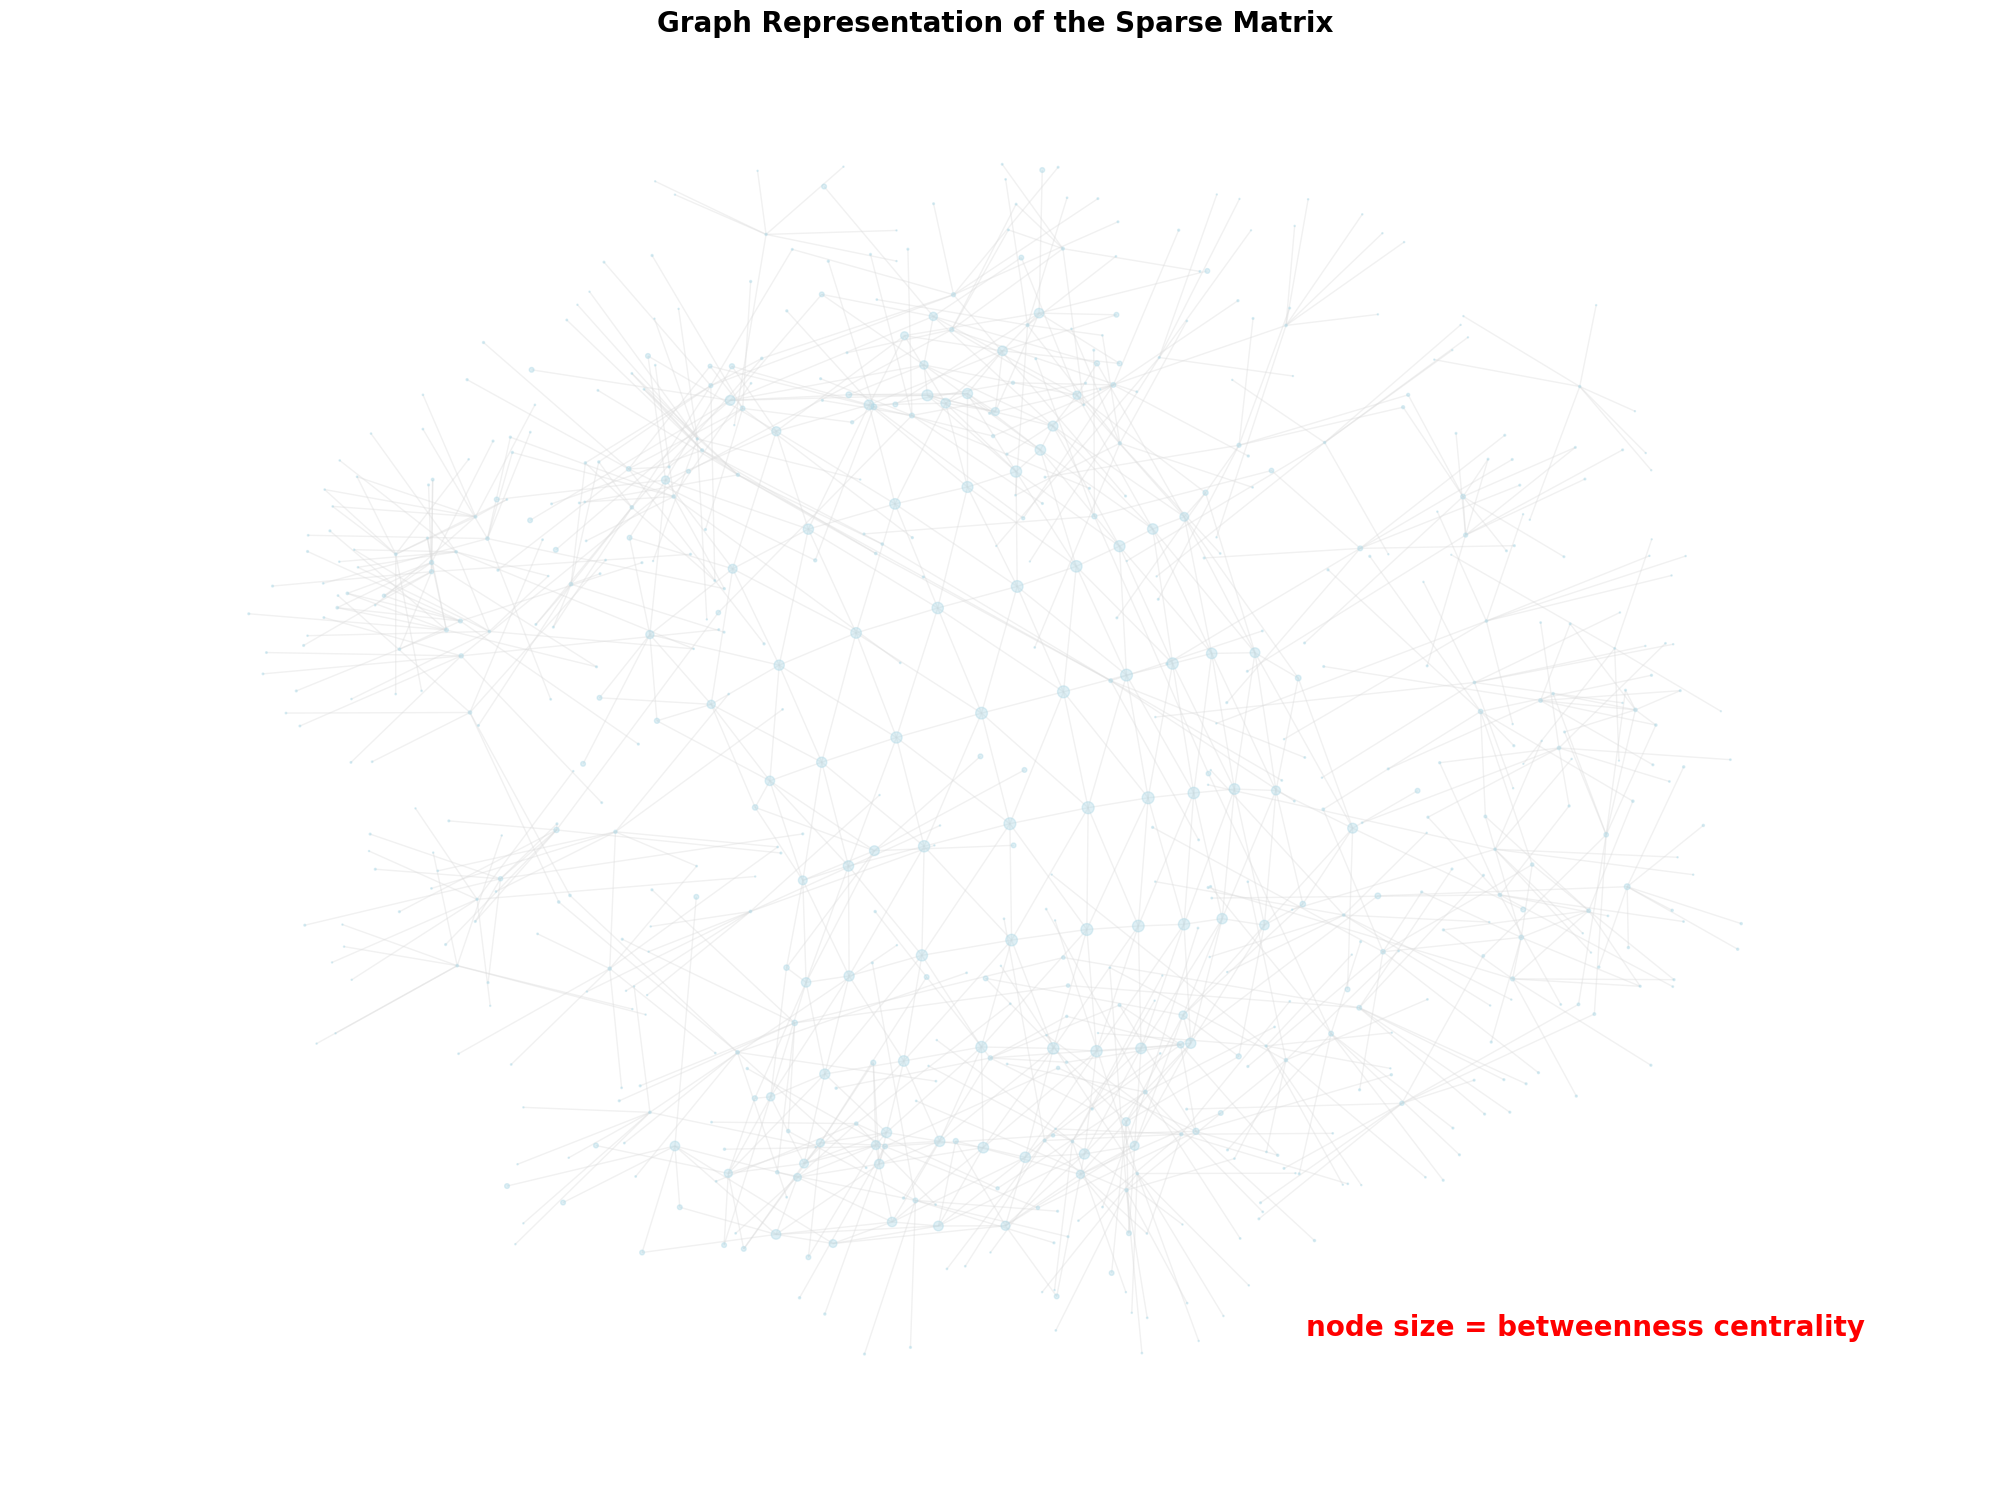

{'Density': 0.004191377023746966, 'Average Path Length': 3.5281385281385282, 'Clustering Coefficient': 0.16489383632240776, 'Spectral Radius': 7.555450498117368, 'Degree Distribution Plot': 'degree_distribution.png'}


In [18]:
import os
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import pandas as pd
import scipy

run = 0

def grid_to_adjacency(grid):

    grid_size_row, grid_size_col = grid.shape
    if grid_size_row != grid_size_col:
        raise ValueError("The grid must be square (grid_size x grid_size).")
    grid_size = grid_size_row
    n_nodes = grid_size * grid_size
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

    # Helper function to compute node indices
    def node_index(row, col):
        return row * grid_size + col

    # Traverse the grid to establish connections
    for row in range(grid_size):
        for col in range(grid_size):
            if grid[row, col] == 0:
                continue

            current_node = node_index(row, col)

            # Right connection
            if col + 1 < grid_size and grid[row, col + 1] == 1:
                adjacency[current_node, node_index(row, col + 1)] = 1

            # Left connection
            if col - 1 >= 0 and grid[row, col - 1] == 1:
                adjacency[current_node, node_index(row, col - 1)] = 1

            # Down connection
            if row + 1 < grid_size and grid[row + 1, col] == 1:
                adjacency[current_node, node_index(row + 1, col)] = 1

            # Up connection
            if row - 1 >= 0 and grid[row - 1, col] == 1:
                adjacency[current_node, node_index(row - 1, col)] = 1

            # Diagonal connections
            # Bottom-right
            if row + 1 < grid_size and col + 1 < grid_size and grid[row + 1, col + 1] == 1:
                adjacency[current_node, node_index(row + 1, col + 1)] = 1

            # Bottom-left
            if row + 1 < grid_size and col - 1 >= 0 and grid[row + 1, col - 1] == 1:
                adjacency[current_node, node_index(row + 1, col - 1)] = 1

            # Top-right
            if row - 1 >= 0 and col + 1 < grid_size and grid[row - 1, col + 1] == 1:
                adjacency[current_node, node_index(row - 1, col + 1)] = 1

            # Top-left
            if row - 1 >= 0 and col - 1 >= 0 and grid[row - 1, col - 1] == 1:
                adjacency[current_node, node_index(row - 1, col - 1)] = 1

    # Make sure adjacency matrix is symmetric (einai undirected graph)
    adjacency = adjacency | adjacency.T

    return adjacency


def compute_metrics(input_matrix, run_number, output_dir):

    adjacency_matrix = grid_to_adjacency(input_matrix);
    G = nx.from_scipy_sparse_array(scipy.sparse.csr_matrix(adjacency_matrix))

    # Exclude nodes with a degree of 0 - FASTER!!!!
    nodes_with_zero_degree = [node for node, degree in dict(G.degree()).items() if degree == 0]
    G.remove_nodes_from(nodes_with_zero_degree)

    print(G)

    # # Draw the graph
    # plt.figure(figsize=(10, 10))
    # pos = nx.spring_layout(G)  # Use spring layout for visualization
    # nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=500, font_size=12)
    # nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.1f}' for u, v, d in G.edges(data=True)})
    # plt.title("Graph Representation of the Sparse Matrix")
    # plt.show()

    # Compute centrality
    centrality = nx.betweenness_centrality(G, endpoints=True) # k=10 for faster computation

    # k = 0.15

    # Draw the graph (Improved visualization)
    fig, ax = plt.subplots(figsize=(20, 15))
    pos = nx.spring_layout(G, k=0.15, seed=4572321)  # Consistent spring layout
    node_size = [v * 20000 for v in centrality.values()] # Node size based on betweenness
    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=False,
        node_color='lightblue', # You can customize node color
        node_size=node_size,
        edge_color="gainsboro",
        alpha=0.4,
        ax=ax # Draw on the specified axes
    )

    # Title/legend
    font = {"color": "k", "fontweight": "bold", "fontsize": 20}
    ax.set_title("Graph Representation of the Sparse Matrix", font)
    font["color"] = "r"
    ax.text(
        0.80,
        0.10,
        "node size = betweenness centrality",
        horizontalalignment="center",
        transform=ax.transAxes,
        fontdict=font,
    )
    ax.margins(0.1, 0.05) # Improve layout
    fig.tight_layout()
    plt.axis("off")
    plt.show()


    # Metrics! 
    density = nx.density(G)

    for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
        apl = nx.average_shortest_path_length(C)

    # n = adjacency_matrix.shape[0]
    average_clustering = nx.average_clustering(G)

    # # Generate a random graph with the same number of nodes and edges
    # random_graph = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())

    # # Calculate metrics for the random graph
    # random_clustering_coefficient = nx.average_clustering(random_graph)
    # if nx.is_connected(random_graph):
    #     random_average_path_length = nx.average_shortest_path_length(random_graph)
    # else:
    #     largest_cc_random = max(nx.connected_components(random_graph), key=len)
    #     G_random_lcc = random_graph.subgraph(largest_cc_random)
    #     random_average_path_length = nx.average_shortest_path_length(G_random_lcc)
    # 
    # Calculate the small-world coefficient
    # S = (average_clustering / random_clustering_coefficient) / (apl / random_average_path_length)

    eigenvalues = np.linalg.eigvals(adjacency_matrix)
    # Compute the spectral radius (the largest absolute value of the eigenvalues)
    spectral_radius = max(abs(eigenvalues))

    # Plot and save degree distribution
    degree_sequence = [d for n, d in G.degree()]
    if not degree_sequence:
        degree_sequence = [0]  # Handle empty graph case

    unique_degrees, counts = np.unique(degree_sequence, return_counts=True)
    plt.figure(figsize=(8, 6))
    plt.bar(unique_degrees, counts)
    plt.title(f"Degree Distribution for Run {run_number}")
    plt.xlabel("Degree")
    plt.ylabel("Number of Nodes")
    plt.grid(True)
    degree_plot_path = os.path.join(output_dir, f"degree_distribution.png")
    plt.savefig(degree_plot_path)
    plt.close()

    # Calculate betweenness centrality
    betweenness = nx.betweenness_centrality(G)

    # Degree Distribution
    degrees = np.sum(adjacency_matrix, axis=1).astype(int)
    degree_counts = np.bincount(degrees)
    degree_values = np.arange(len(degree_counts))

    return {
        "Density": density,
        "Average Path Length": apl,
        "Clustering Coefficient": average_clustering,
        "Spectral Radius": spectral_radius,
        # "Betweeness Centrality": centrality,
        "Degree Distribution Plot": degree_plot_path
    }


# Define output directory and filename
output_dir = os.path.join(os.getcwd(), "output_plots")
output_filename = os.path.join(os.getcwd(), "Reservoir_Metrics_1.csv")

# Calculate metrics
metrics = compute_metrics(c,1,'')
print(metrics)

In [19]:
# output_filename = os.path.join(os.getcwd(), "c.csv")
# export_tensor_to_csv_numpy(c,output_filename)

In [31]:
import networkx as nx

average_clustering = 0.17
apl = 2.8

# # Generate a random graph with the same number of nodes and edges
random_graph = nx.gnm_random_graph(784, 1124)

# # Calculate metrics for the random graph
random_clustering_coefficient = nx.average_clustering(random_graph)
if nx.is_connected(random_graph):
    random_average_path_length = nx.average_shortest_path_length(random_graph)
else:
    largest_cc_random = max(nx.connected_components(random_graph), key=len)
    G_random_lcc = random_graph.subgraph(largest_cc_random)
    random_average_path_length = nx.average_shortest_path_length(G_random_lcc)

# Calculate the small-world coefficient
S = (average_clustering / random_clustering_coefficient) / (apl / random_average_path_length)

print(S)

251.1394877291607
